In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils
import random,os
from tensorboardX import SummaryWriter
torch.manual_seed(1)

DATA_PATH = os.environ['DATA_PATH']
USE_CUDA = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

### FashionMNIST 

In [42]:
train_dataset = vdatasets.FashionMNIST(root=DATA_PATH+'FM/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_dataset = vdatasets.FashionMNIST(root=DATA_PATH+'FM/',
                               train=False, 
                               transform=transforms.ToTensor(),
                               download=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

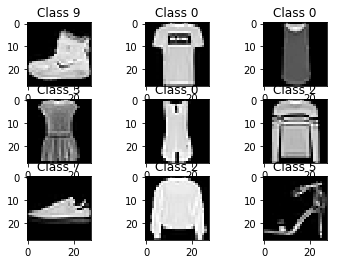

In [43]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_dataset[i][0].squeeze(0).numpy(), cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_dataset[i][1]))

In [44]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1,16,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,return_indices=True)
            )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(16,32,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,return_indices=True)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32*7*7,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    
        self.deconv = nn.ConvTranspose2d(1,1,5,padding=2)
        self.unpooling = nn.MaxUnpool2d(2)

    
    # 첫 번째 레이어의 Activation map을 시각화
    def visualize_layer(self,inputs,layer=None):
        inputs,indices1 = self.conv_layer1(inputs)
        
        featuremaps=[]
#         index = random.choice(range(inputs.size(1)))
        for index in range(inputs.size(1)):
            featuremap = inputs[0][index].view(1,1,inputs.size(2),inputs.size(3))
            f_indices = indices1[0][index].view(1,1,inputs.size(2),inputs.size(3))
            unpooled = self.unpooling(featuremap,f_indices)
            unpooled = F.relu(unpooled)

            # 해당 필터 weight 복사
            self.deconv.weight.data = self.conv_layer1[0].weight.data[index].unsqueeze(0).clone()
            deconved1 = self.deconv(unpooled)
            featuremaps.append(deconved1)
        return featuremaps
        
    def forward(self,inputs):
        inputs,_ = self.conv_layer1(inputs)
        inputs,_ = self.conv_layer2(inputs)
        
        return self.fc(inputs.view(inputs.size(0),-1))
        

In [45]:
EPOCH=3
LR=0.01
BATCH_SIZE=64

model = CNN()
if USE_CUDA:
    model = model.cuda()
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 포함하고 있음
optimizer = optim.Adam(model.parameters(), lr=LR)

In [46]:
for epoch in range(EPOCH):
    losses=[]
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs), Variable(targets)
        if USE_CUDA:
            inputs,targets = inputs.cuda(),targets.cuda()
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.data[0])
        if i % 100 == 0:
            print("[%d/%d] [%03d/%d] mean_loss : %.3f" % (epoch,EPOCH,i,len(train_loader),np.mean(losses)))
            losses=[]

[0/3] [000/938] mean_loss : 2.306
[0/3] [100/938] mean_loss : 0.779
[0/3] [200/938] mean_loss : 0.473
[0/3] [300/938] mean_loss : 0.414
[0/3] [400/938] mean_loss : 0.393
[0/3] [500/938] mean_loss : 0.368
[0/3] [600/938] mean_loss : 0.355
[0/3] [700/938] mean_loss : 0.350
[0/3] [800/938] mean_loss : 0.356
[0/3] [900/938] mean_loss : 0.342
[1/3] [000/938] mean_loss : 0.328
[1/3] [100/938] mean_loss : 0.313
[1/3] [200/938] mean_loss : 0.315
[1/3] [300/938] mean_loss : 0.306
[1/3] [400/938] mean_loss : 0.337
[1/3] [500/938] mean_loss : 0.313
[1/3] [600/938] mean_loss : 0.308
[1/3] [700/938] mean_loss : 0.307
[1/3] [800/938] mean_loss : 0.316
[1/3] [900/938] mean_loss : 0.318
[2/3] [000/938] mean_loss : 0.315
[2/3] [100/938] mean_loss : 0.280
[2/3] [200/938] mean_loss : 0.285
[2/3] [300/938] mean_loss : 0.294
[2/3] [400/938] mean_loss : 0.282
[2/3] [500/938] mean_loss : 0.276
[2/3] [600/938] mean_loss : 0.309
[2/3] [700/938] mean_loss : 0.300
[2/3] [800/938] mean_loss : 0.295
[2/3] [900/938

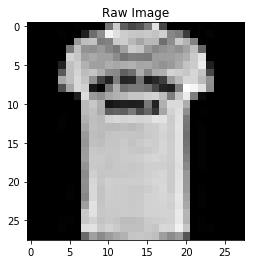

Featuremaps from layer1


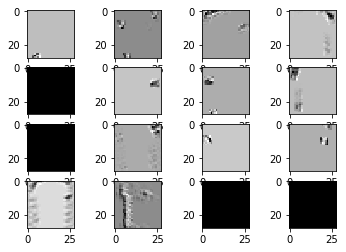

In [47]:
model = model.cpu()
input = random.choice(test_dataset)[0]

plt.imshow(input.squeeze().numpy(), cmap='gray', interpolation='none')
plt.title("Raw Image")
plt.show()

features = model.visualize_layer(Variable(input.unsqueeze(0)))

print("Featuremaps from layer1")
for i,feature in enumerate(features):
    plt.subplot(4,4,i+1)
    plt.imshow(feature.squeeze().data.numpy(), cmap='gray', interpolation='none')


* 웨이트 순으로 정렬 후, 탑 9개만 보여주기
* 레이어별로 보여주기
* CIFAR-10 적용